/tmp/ipykernel_8279/1437132374.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Fs = float(analysisData['samples'][0])


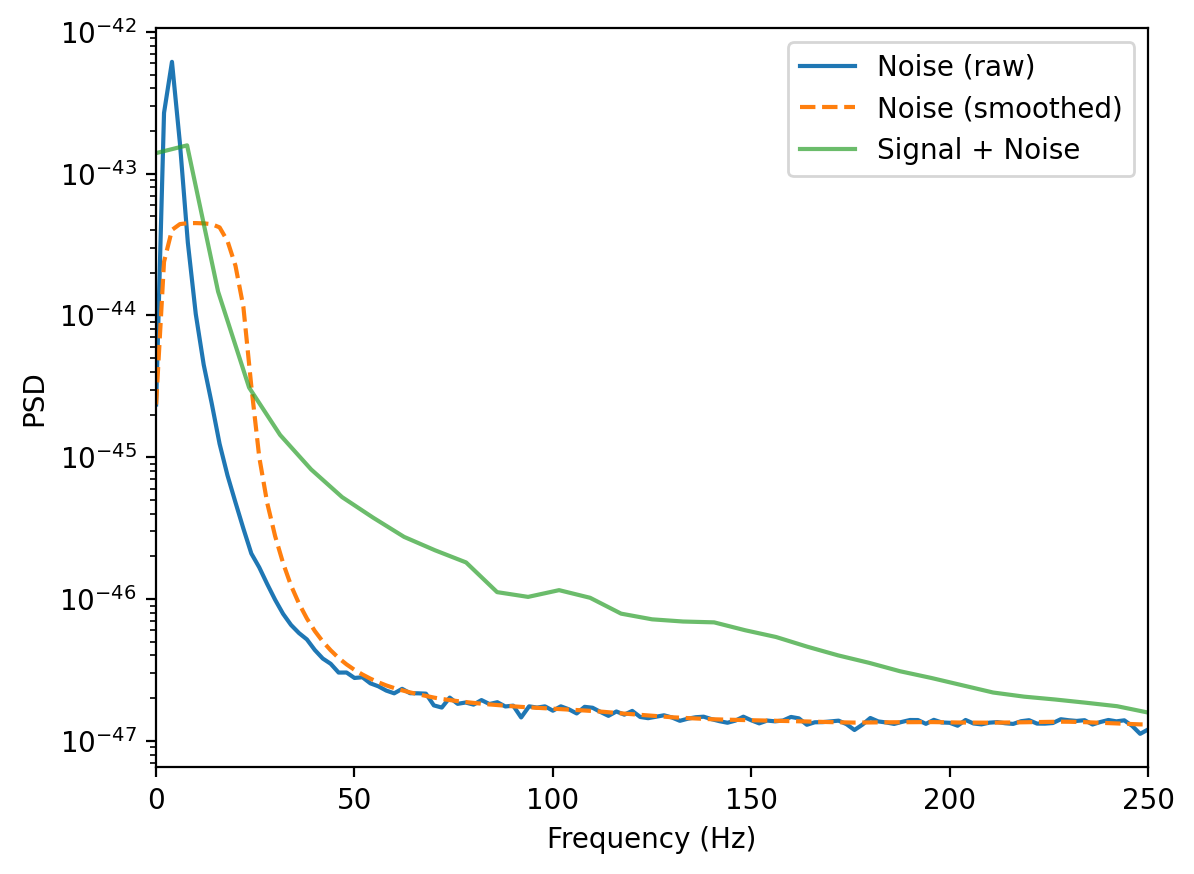

In [1]:
import cupy as cp
import scipy.io as scio
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d
from PSO_GPU_main import *
import matplotlib.pyplot as plt
import os
import  numpy as np
from scipy.signal import find_peaks

# Constants
G = 6.67430e-11
c = 2.998e8
M_sun = 1.989e30
pc = 3.086e16

TrainingData = scio.loadmat('../generate_ligo/noise.mat')
analysisData = scio.loadmat('../generate_ligo/data.mat')

# Convert data to CuPy arrays
dataY = cp.asarray(analysisData['data'][0])
# dataY = cp.asarray(analysisData['noise'][0])
nSamples = dataY.size
Fs = float(analysisData['samples'][0])
# Fs = 2000
# Search range parameters (r, m_c, tc, phi_c, mlz, y)
rmin = cp.array([-2, 0, 0, 0, 4, -5])   # 对应参数范围下限
rmax = cp.array([4, 3, 10, 2*np.pi, 14, 1])  # 对应参数范围上限

# Time domain setup
dt = 1/Fs
t = cp.linspace(-90, 10, nSamples)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2

# PSD estimation (CPU operation)
training_noise = TrainingData['noise'][0]
[f, pxx] = welch(training_noise, fs=Fs,
                 window='hamming', nperseg=int(Fs/2),
                 noverlap=None, nfft=None,
                 detrend=False)

# Smooth PSD
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b, 1, pxx)

# Interpolate PSD
kNyq = int(cp.floor(nSamples/2)) + 1
posFreq = cp.arange(0, kNyq)*Fs/nSamples
psdPosFreq = cp.asarray(interp1d(f, pxxSmth)(cp.asnumpy(posFreq)))

# Plot PSDs
plt.figure(dpi=200)
plt.plot(f, pxx, label='Noise (raw)')
plt.plot(f, pxxSmth, label='Noise (smoothed)', linestyle='--')

# Convert data to CPU for Welch
dataY_cpu = cp.asnumpy(dataY)
[f, pxxY] = welch(dataY_cpu, fs=Fs,
                  window='hamming', nperseg=256,
                  noverlap=None, nfft=None,
                  detrend=False)

plt.plot(np.abs(f), pxxY, label='Signal + Noise', alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xlim(0, 250)
plt.legend()
plt.savefig('output_psd.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

In [2]:
# PSO input parameters
inParams = {
    'dataX': t,
    'dataY': dataY,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# Number of PSO runs
nRuns = 15
# Run PSO optimization
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

Run 15: 100%|██████████| 2000/2000 [00:07<00:00, 275.29it/s]


/home/ywq/anaconda3/envs/Ubuntu/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ywq/anaconda3/envs/Ubuntu/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


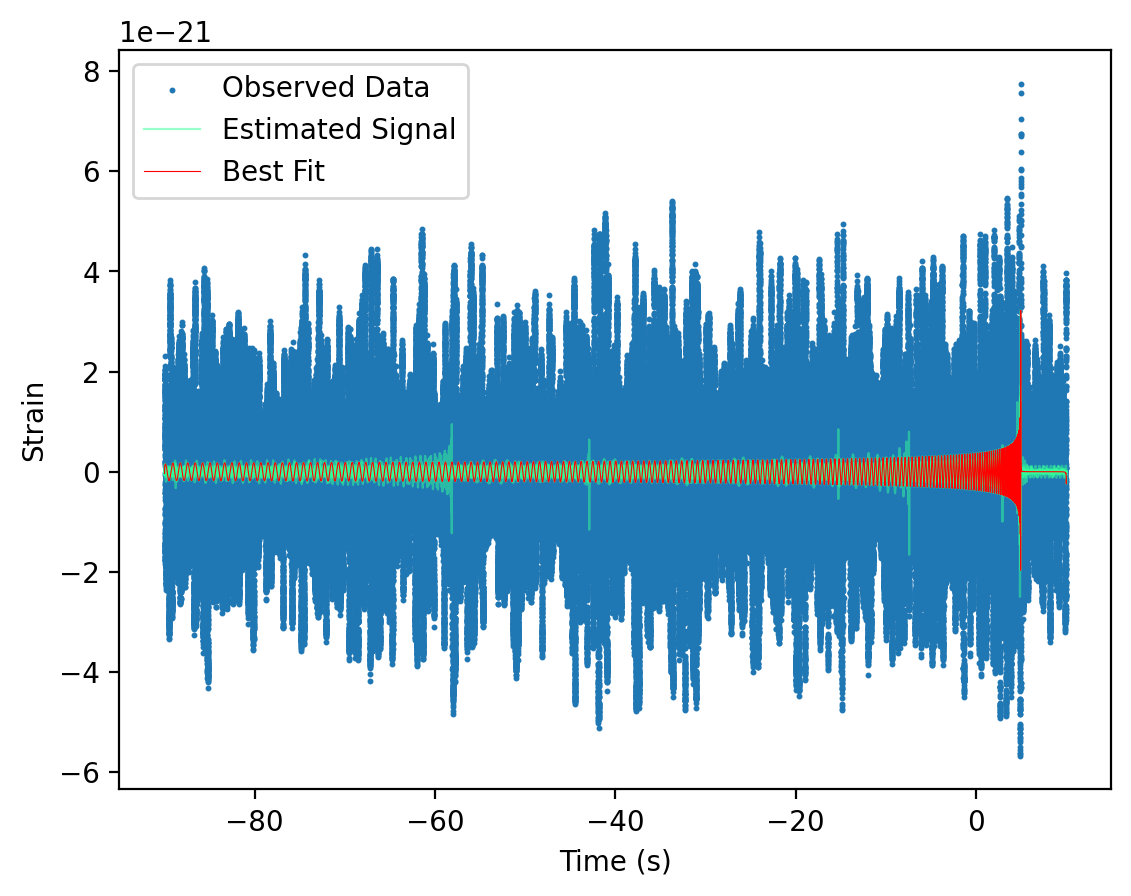

In [3]:
# Plotting results
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.scatter(cp.asnumpy(t), cp.asnumpy(dataY), marker='.', s=5, label='Observed Data')

# Plot all estimated signals
for lpruns in range(nRuns):
    est_sig = outResults['allRunsOutput'][lpruns]['estSig']
    ax.plot(cp.asnumpy(t), est_sig,
            color=[51/255, 255/255, 153/255], lw=0.8, alpha=0.5, label='Estimated Signal' if lpruns == 0 else "")

# Highlight best signal
ax.plot(cp.asnumpy(t), outResults['bestSig'], 'red', lw=0.4, label='Best Fit')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.savefig('output_signal.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

In [4]:
# Print results
print('\n============= Final Results =============')
print(f"Best Fitness (GLRT): {outResults['bestFitness']:.4f}")
print(f"r : {10**outResults['r']:.4f}")
print(f"Mc: {10**outResults['m_c']:.4f}")
print(f"tc: {outResults['tc']:.4f}")
print(f"phi_c: {outResults['phi_c']/np.pi:.4f}")
print(f"mlz: {10**outResults['mlz']:.4e}")
print(f"y: {10 ** outResults['y']:.4f}")
print(f"SNR: {cp.sqrt(-outResults['bestFitness']):.2f}")


============= Final Results =============
Best Fitness (GLRT): -1286.8350
r : 18.0454
Mc: 149.0877
tc: 4.9453
phi_c: 1.2694
mlz: 1.7072e+05
y: 0.0002
SNR: 35.87


In [5]:
for lpruns in range(nRuns):
    print(f"\nRun No.{lpruns+1}:")
    print(f"bestFitness={float(outStruct[lpruns]['bestFitness']):.4f}")
    print(f"r = {float(10 ** outResults['allRunsOutput'][lpruns]['r']):.4f}")
    print(f"m_c = {float(10 ** outResults['allRunsOutput'][lpruns]['m_c']):.4f}")
    print(f"tc = {float(outResults['allRunsOutput'][lpruns]['tc']):.4f}")
    print(f"phi_c = {float(outResults['allRunsOutput'][lpruns]['phi_c'])/np.pi:.4f}")
    print(f"mlz = {float(10 ** outResults['allRunsOutput'][lpruns]['mlz']):.4e}")
    print(f"y = {float(10 ** outResults['allRunsOutput'][lpruns]['y']):.4f}")
    print(f"SNR = {float(cp.sqrt(-outStruct[lpruns]['bestFitness'])):.2f}")



Run No.1:
bestFitness=-87.0385
r = 0.0461
m_c = 2.8081
tc = 8.6090
phi_c = 0.6875
mlz = 1.0645e+08
y = 0.0006
SNR = 9.33

Run No.2:
bestFitness=-441.3747
r = 0.1415
m_c = 19.8714
tc = 4.9570
phi_c = 1.1413
mlz = 2.5201e+11
y = 0.1060
SNR = 21.01

Run No.3:
bestFitness=-307.9246
r = 0.7154
m_c = 456.8089
tc = 4.9411
phi_c = 0.7222
mlz = 1.7267e+09
y = 0.0208
SNR = 17.55

Run No.4:
bestFitness=-229.2306
r = 1.5740
m_c = 5.7847
tc = 5.1956
phi_c = 0.7752
mlz = 8.9997e+11
y = 0.0005
SNR = 15.14

Run No.5:
bestFitness=-239.4435
r = 0.0142
m_c = 122.2621
tc = 4.5659
phi_c = 1.5025
mlz = 6.2863e+08
y = 3.4305
SNR = 15.47

Run No.6:
bestFitness=-1162.3452
r = 5.2751
m_c = 52.0547
tc = 4.8601
phi_c = 0.9383
mlz = 1.5846e+12
y = 4.3499
SNR = 34.09

Run No.7:
bestFitness=-917.5333
r = 1.9202
m_c = 92.6801
tc = 4.8934
phi_c = 0.8571
mlz = 3.9025e+13
y = 0.0970
SNR = 30.29

Run No.8:
bestFitness=-21.4491
r = 0.2808
m_c = 1.0063
tc = 8.8659
phi_c = 1.6343
mlz = 5.7330e+11
y = 0.0609
SNR = 4.63

Run

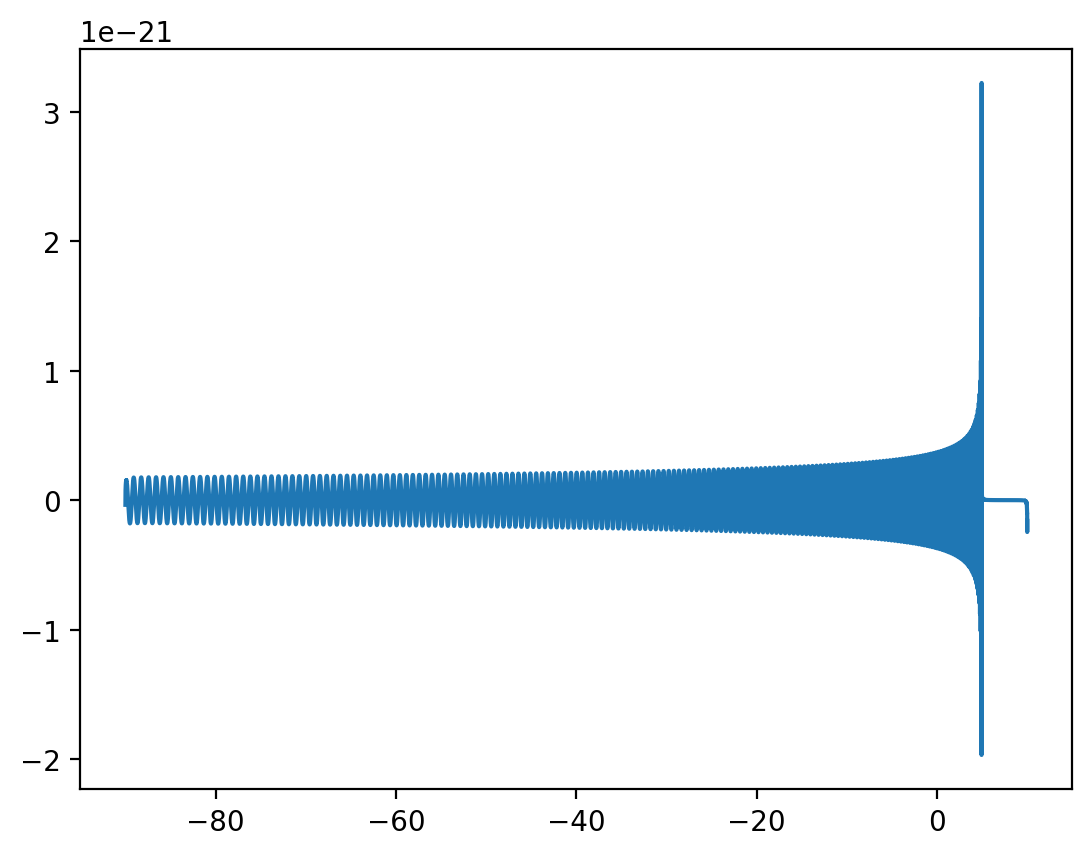

In [6]:
fig = plt.figure(dpi = 200)
plt.plot(cp.asnumpy(t),outResults['bestSig'],label = 'Best signal')
plt.savefig('BestSignal.png',dpi = 200,bbox_inches ='tight')